FINAL DRAFT OF THIS 
Inputs: cdom files 
outputs: wavelenths.csv, plot.png, outputs.csv
    
    the only cells that need edits are at the top 
    they are labled "with edit here"
    
    Hanna Bridgham 
    6/6/2022


In [36]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [37]:
#EDIT HERE
####################################
# This returns a list of names (strings) of files that have the .txt extension. 
# You should provide the path
files = glob.glob('../../../IRL22SU/WC_RHZ_ABS_IRL22SU_*/*.txt')
# You should add the path of your outputs 
path_1 = '../../../IRL22SU/WC_RHZ_ABS_IRL22SU_Pchip_wavelenths.csv'
path_2 = "../../../IRL22SU/WC_RHZ_ABS_IRL22SU_plot.png"
path_3 = '../../../IRL22SU/WC_RHZ_ABS_IRL22SU_outputs.csv'
files

['../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223400_Absorbance__0__00.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223400_Absorbance__1__01.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223400_Absorbance__2__02.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223401_Absorbance__0__03.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223401_Absorbance__1__04.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223401_Absorbance__2__05.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223402_Absorbance__0__06.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223402_Absorbance__1__07.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223402_Absorbance__2__08.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223403_Absorbance__0__09.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223404_Absorbance__0__09.txt',
 '../../../IRL22SU\\WC_RHZ_ABS_IRL22SU_2234__Sbeach\\223404_Absorbance__1__1

In [38]:
#EDIT HERE
####################################
#first Identify what wavegide was used then uncomment the correct waveguide 
#WG 50 #1 : 190987 : 48.9
#WG 50 #2 : 190991 : 48.75
#WG 50 #3 : 192856 : 48.8 

X = .01 #1 cm waveguide 



PART 1: GRAPHS AND WAVELENGTHS 

we use pchip to process the data to get the wavelenths in whole numbers 

we will save this to a output tabel 

we will also save the baseline correction 

In [39]:
#FINAL FUNTION 
#see above for the breakdown of diff parts 
def GET_CDOM_DATA(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    #bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    #df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [32]:
#EDIT HERE
n = 5 # how many underscore breaks 
stri = 0 # the selected underscore break 
split = 2 #spit in the file name string 

####################################
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
#edit the slpit function to get the abs names 
frames = []
for f in files:
    df = GET_CDOM_DATA(f) # runs the processing function 
    ID = f.split("\\")[split] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=n).str[stri]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df

,223400,223401,223402,223403,223404,223405,223407,223408,223409,223410,...,223502,223503,223504,223505,223506,223507,223508,223509,223511,223512
wl,,,,,,,,,,,,,,,,,,,,,
189,-115.065557,-204.130243,-257.674993,-283.683540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
190,-115.065557,-204.130243,-257.674993,-283.683540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
191,-118.863844,-223.408885,-275.338606,-296.579285,44.518400,0.000000,0.000000,0.000000,-15.929972,-120.812926,...,0.000000,-118.828365,-202.640934,0.000000,0.000000,0.000000,0.000000,0.000000,-77.309384,-116.330302
192,-101.728235,-178.929429,-235.359344,-259.048097,-0.233008,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-230.109109,-381.612680,176.201629,0.000000,0.000000,0.000000,0.000000,-564.382653,-632.820669
193,-208.765482,-311.719786,-359.565654,-387.152367,0.000000,0.000000,0.000000,0.000000,-43.068194,0.000000,...,0.000000,0.000000,0.000000,42.577306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,7.154183,9.157236,24.982999,30.607203,-2.464343,5.320963,16.888568,21.426249,-2.480369,6.088707,...,49.683481,5.159926,26.012938,8.074236,14.277253,3.484027,11.626928,14.092574,7.731340,4.100123
877,4.413014,9.035688,25.601605,33.005732,-3.233739,5.369945,15.799315,21.195696,0.457942,9.280269,...,53.028721,6.332810,28.011849,6.504846,13.647130,3.162645,11.796917,14.850052,7.940076,5.002276
878,6.736963,10.945620,26.976496,37.013704,-1.387724,5.906063,21.108622,25.991444,-0.106021,7.292397,...,59.779588,5.451809,29.450441,7.434693,16.370522,3.676635,15.399893,16.484967,8.758613,5.553538


In [40]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'
bcorr = df[486:537].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
df = df[:] - df[486:537].mean(axis=0) # here we correct the data by that average 
df

,223400,223401,223402,223403,223404,223405,223407,223408,223409,223410,...,223502,223503,223504,223505,223506,223507,223508,223509,223511,223512
wl,,,,,,,,,,,,,,,,,,,,,
189,-119.315664,-201.486424,-257.834480,-283.202389,4.823579,2.372993,2.357852,2.396895,1.927631,-0.187669,...,-0.120561,0.948325,0.841445,-0.959556,8.816139,1.784071,2.546359,2.062334,-4.403087,0.386612
190,-119.315664,-201.486424,-257.834480,-283.202389,4.823579,2.372993,2.357852,2.396895,1.927631,-0.187669,...,-0.120561,0.948325,0.841445,-0.959556,8.816139,1.784071,2.546359,2.062334,-4.403087,0.386612
191,-123.113951,-220.765066,-275.498092,-296.098134,49.341979,2.372993,2.357852,2.396895,-14.002340,-121.000595,...,-0.120561,-117.880039,-201.799489,-0.959556,8.816139,1.784071,2.546359,2.062334,-81.712471,-115.943690
192,-105.978342,-176.285610,-235.518831,-258.566946,4.590571,2.372993,2.357852,2.396895,1.927631,-0.187669,...,-0.120561,-229.160783,-380.771235,175.242074,8.816139,1.784071,2.546359,2.062334,-568.785740,-632.434056
193,-213.015589,-309.075967,-359.725141,-386.671216,4.823579,2.372993,2.357852,2.396895,-41.140562,-0.187669,...,-0.120561,0.948325,0.841445,41.617750,8.816139,1.784071,2.546359,2.062334,-4.403087,0.386612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,2.904076,11.801055,24.823512,31.088354,2.359237,7.693956,19.246419,23.823143,-0.552737,5.901038,...,49.562920,6.108252,26.854383,7.114680,23.093392,5.268098,14.173288,16.154908,3.328254,4.486736
877,0.162906,11.679507,25.442119,33.486883,1.589841,7.742938,18.157166,23.592591,2.385574,9.092600,...,52.908159,7.281136,28.853294,5.545290,22.463269,4.946716,14.343277,16.912386,3.536989,5.388888
878,2.486855,13.589439,26.817009,37.494855,3.435856,8.279055,23.466474,28.388339,1.821611,7.104728,...,59.659027,6.400134,30.291886,6.475138,25.186661,5.460705,17.946253,18.547301,4.355526,5.940150


In [41]:
#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
Abs_data = df.transpose(copy=False)
Abs_data['bcorr'] = bcorr
Abs_data

#save it as a CSV to the propor location with the correct file name
Abs_data.to_csv(path_1)

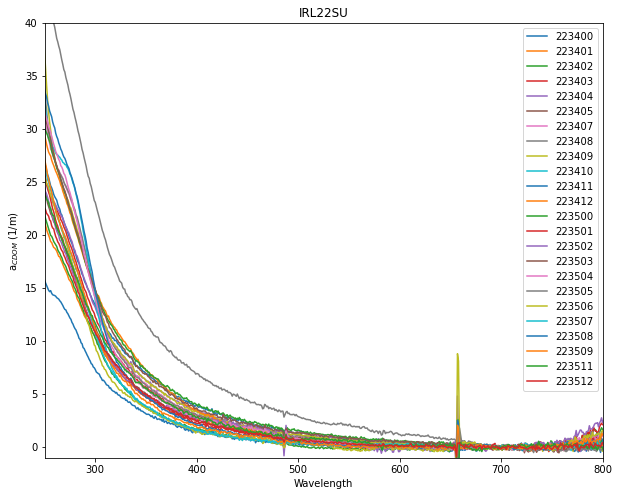

In [42]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-1,40)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("IRL22SU")

plt.savefig(path_2)

PART 2: REGRESSIONS

I need an output table for each sampling event with the sample number

we will get this with 2 regression methods 

there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: $A(g)=Ae^{slope}$
2. Hyperbolic (HM) where: $A(g)=A(\frac{wl}{532})^{slope}$

corresponding parameters = abs 254, abs 280, abs 320, abs 412, abs 444 

corresponding parameters = the spectral slope of 275 to 295, the spectral slope of 350 to 400, the spectral slope of 275 to 700

corresponding parameters = spectral ratio of spectral slope of 275 to 295 and the spectral slope of 350 to 400

corresponding parameters = baseline correction we used, so the b term 


In [18]:
#OPEN OUR FILES AND MAKE ABSORBANCE TO ABSORPTION
def open_file_abs_base_cor(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    return df

In [19]:
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = open_file_abs_base_cor(f) # runs the processing function 
    ID = f.split("\\")[split] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=n).str[stri]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = df.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,223400,223401,223402,223403,223404,223405,223407,223408,223409,223410,...,223503,223504,223505,223506,223507,223508,223509,223511,223512,wl
wl,,,,,,,,,,,,,,,,,,,,,
189.2794,-115.065557,-204.130243,-257.674993,-283.68354,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,189.2794
189.6618,-115.065557,-204.130243,-257.674993,-283.68354,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,189.6618
190.0441,-115.065557,-204.130243,-257.674993,-283.68354,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,190.0441
190.4264,-174.390837,-270.771387,-322.297173,-341.90338,0.000000,0.00000,0.000000,0.000000,-26.737830,-346.125547,...,-196.668523,-339.231900,0.000000,0.000000,-120.58508,-229.563040,-236.510423,0.000000,0.000000,190.4264
190.8087,-82.831233,-162.768363,-214.370917,-232.69512,36.272250,0.00000,0.000000,0.000000,-2.287647,-150.002067,...,-238.030403,-405.919103,0.000000,0.000000,0.00000,0.000000,0.000000,43.649527,0.000000,190.8087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,5.995477,14.055977,34.276317,41.56915,-3.239553,4.09934,20.074483,25.494210,0.790697,9.887547,...,5.043570,32.042407,10.854807,22.062740,4.88236,17.180380,18.093903,9.803103,7.131623,880.5978
880.8884,6.594257,13.979210,32.794720,41.73036,-0.337773,6.95506,23.160503,30.284450,-0.399187,8.160297,...,6.363957,33.808040,8.306153,21.786380,3.75389,16.980787,18.239760,9.142910,6.218100,880.8884
881.1790,7.638283,13.864060,32.311090,44.37881,-1.105440,4.55994,22.262333,28.019833,-2.287647,8.505747,...,8.144943,36.180130,8.306153,21.241337,3.75389,16.466450,19.920950,8.666957,7.216067,881.1790


In [20]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [21]:
#HERE DO THE WHOLE EXPO AS A LOOP FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)
    pams_295 = (10, .001, 0)
    pams_350 = (10, .001, 0)
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = exp_equation(252, a, s, b)
    abs_280 = exp_equation(280, a, s, b)
    abs_320 = exp_equation(320, a, s, b)
    abs_350 = exp_equation(350, a, s, b)
    abs_412 = exp_equation(412, a, s, b)
    abs_440 = exp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_SEM':[ss_275_700],
        'ss_275_295_SEM':[ss_275_295],
        'ss_350_400_SEM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_SEM':[sr],
        'abs_254_SEM':[abs_254], 
        'abs_280_SEM':[abs_280],
        'abs_320_SEM':[abs_320], 
        'abs_350_SEM':[abs_350],
        'abs_412_SEM':[abs_412], 
        'abs_440_SEM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

ss_outs

,ss_275_700_SEM,ss_275_295_SEM,ss_350_400_SEM,R2_275_700,R2_275_295,R2_350_400,SR_SEM,abs_254_SEM,abs_280_SEM,abs_320_SEM,abs_350_SEM,abs_412_SEM,abs_440_SEM
sample,,,,,,,,,,,,,
223400,0.012816,0.008431,0.014849,0.993825,0.998293,0.991539,0.567746,29.339667,21.775265,14.746862,11.396888,7.479663,6.506365
223401,0.015628,0.012920,0.016562,0.995322,0.997760,0.984982,0.780087,19.135267,11.522539,5.076837,2.299010,-0.582745,-1.207351
223402,0.018549,0.005347,0.015678,0.996421,0.998025,0.983268,0.341015,25.031488,14.914519,7.132201,4.112958,1.341570,0.821383
223403,0.015536,0.008357,0.014019,0.995383,0.998492,0.985579,0.596152,25.901395,16.604833,8.709698,5.296048,1.740988,0.966997
223404,0.015181,0.001089,0.012141,0.993409,0.998671,0.991572,0.089710,22.334706,13.078523,5.125106,1.642145,-2.040001,-2.855690
223405,0.016975,0.004989,0.013964,0.995328,0.998783,0.989624,0.357264,23.100587,13.597730,5.900570,2.740224,-0.357632,-0.986116
223407,0.018684,0.000011,0.013424,0.992180,0.996948,0.991095,0.000813,33.455266,19.044514,8.008479,3.747843,-0.141015,-0.866047
223408,0.019118,0.000011,0.013451,0.990851,0.995853,0.992971,0.000793,34.149099,19.195698,7.905578,3.614563,-0.232151,-0.934028
223409,0.017248,0.000011,0.012093,0.993497,0.998108,0.992237,0.000885,30.835256,18.453417,8.513755,4.472516,0.556180,-0.227754


In [22]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")
    
ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_SEM'] = np.nan
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_SEM = ss_outs['ss_275_700_SEM']
ss_275_295_SEM = ss_outs['ss_275_295_SEM']
ss_350_400_SEM = ss_outs['ss_350_400_SEM']
abs_254_SEM = ss_outs['abs_254_SEM']
abs_280_SEM = ss_outs['abs_280_SEM']
abs_320_SEM = ss_outs['abs_320_SEM']
abs_412_SEM = ss_outs['abs_412_SEM']
abs_440_SEM = ss_outs['abs_440_SEM']
SR_SEM = ss_outs['SR_SEM']

THE FITS ARE GOOD, YAY!


In [23]:
#HYPERBOLIC REGRESSION A(g)=A(wl/532)^slope
def hyp_equation(x, a, s, b):
    return a * ((x/532)**-s) + b

In [24]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (.001, 11, 0)
    pams_295 = (1, 0, 1)
    pams_350 = (1, 1, 1)
    
    maxfev = 1000000
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = hyp_equation(252, a, s, b)
    abs_280 = hyp_equation(280, a, s, b)
    abs_320 = hyp_equation(320, a, s, b)
    abs_350 = hyp_equation(350, a, s, b)
    abs_412 = hyp_equation(412, a, s, b)
    abs_440 = hyp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_HM':[ss_275_700],
        'ss_275_295_HM':[ss_275_295],
        'ss_350_400_HM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_HM':[sr],
        'abs_254_HM':[abs_254], 
        'abs_280_HM':[abs_280],
        'abs_320_HM':[abs_320], 
        'abs_350_HM':[abs_350],
        'abs_412_HM':[abs_412], 
        'abs_440_HM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

In [25]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_HM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_HM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_HM'] = np.nan
    
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_HM = ss_outs['ss_275_700_HM']
ss_275_295_HM = ss_outs['ss_275_295_HM']
ss_350_400_HM = ss_outs['ss_350_400_HM']
abs_254_HM = ss_outs['abs_254_HM']
abs_280_HM = ss_outs['abs_280_HM']
abs_320_HM = ss_outs['abs_320_HM']
abs_412_HM = ss_outs['abs_412_HM']
abs_440_HM = ss_outs['abs_440_HM']
SR_HM = ss_outs['SR_HM']

THE FITS ARE GOOD, YAY!


PART 3: MAKE ESTIMATE OF INFLECTION 

So at a lot of these there is an infection at around 350 nm 

We need a way to estimate that inflection 

we are going to look for inflections between 300 and 400 nm and quantify them 


In [26]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [27]:
#HERE WE FIND THE INTIGRAL OF ALL THE SAMPLE FOR 350 INFLECTION 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #define where we expect to find the inflection 
    ydata = df[(df['wl']>=300) & (df['wl']<=400)][col]
    xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    #here we take evething not in the infelction for the abs data
    ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][col]
    ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][col]
    ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)
    
    #here we take evething not in the infelction for the wl data
    xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
    xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
    xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)
    
    #here we make them both arrays so we can doo math 
    ydata_r = np.asarray(ydata_r, dtype=float).ravel()
    xdata_r = np.asarray(xdata_r, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams = (1, .001, 0)
    
    #here we do an expodental fit for just the data where we expect there to de no inflection 
    #aka, what the regression would be without the inflection 
    params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
    a, s, b = params
    
    #here we calculate the R squared of that regressions fit 
    squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
    squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    #here we take the differance of the accual data and the regressions fit that dident have that data 
    diffs = ydata - exp_equation(xdata, a, s, b)
    
    #here we normalize the data 
    diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs))
    
    #here we flaten the data
    y1 = xdata[0]
    y2 = xdata[273]
    x1 = diffs[0]
    x2 = diffs[273]
    m = (x2 - x1)/(y2 - y1)
    mx = m * y1
    b = x1 - mx
    
    diffs = diffs - ((m*xdata)+b)
    
    #here we calculate the intigral 
    inter = scipy.integrate.simps(ydata, x=diffs, even='avg')
    
    #plt.plot(xdata, diffs, 'ko', label='data')
    #plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')
    #plt.show()
    #print('The offset of the gaussian baseline is', gaus_baseline)
    #print('The center of the gaussian fit is', center_gaus)
    #print('The sigma of the gaussian fit is', sigma)
    #print('The maximum intensity of the gaussian fit is', H + A)
    #print('The Amplitude of the gaussian fit is', A)
    #print('The FWHM of the gaussian fit is', FWHM)
    
    #here we define some columns for a new data frame with the sample, the R2, and the diffs intigral 
    dict = {'sample':[columnName],
        '350_intergration':[inter],
        'R2':[rSquared]}
    diff = pd.DataFrame(dict)
    
    #here we set the index and append the data together 
    diffs = diff.set_index('sample', drop=True)
    Frames.append(diffs) # adds the new col from each scan to a part of frames 
    
    
diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

In [28]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

R_level = .95 #set x to the r2 value you want to test

min_1 = diffs['R2'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

diffs.loc[diffs.R2 < R_level, '350_intergration'] = np.nan

THE FITS ARE GOOD, YAY!


In [29]:
#NOW WE SAVE ALL THE VALUSE WE WANTED TO A TABEL 
outputs = pd.concat([ss_275_700_SEM, ss_275_295_SEM, ss_350_400_SEM,
                    ss_275_700_HM, ss_275_295_HM, ss_350_400_HM,
                    abs_254_SEM, abs_280_SEM, abs_320_SEM, abs_412_SEM, abs_440_SEM,
                    abs_254_HM, abs_280_HM, abs_320_HM, abs_412_HM, abs_440_HM,
                    SR_SEM, SR_HM], axis=1)
#outputs = outputs.rename(columns={0: 'baseline_correction', 1: 'abs_254',
#                                  2: 'abs_280', 3: 'abs_320', 4: 'abs_412', 5: 'abs_444'})
outputs['350_intergration'] = diffs['350_intergration']
outputs 
#SAVE IT 
outputs.to_csv(path_3)